In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [3]:
dataset=pd.read_csv('dataset.csv')

In [4]:
dataset.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
spotify_tracks = dataset[dataset['track_genre'].isin(['pop', 'country', 'hip-hop', 'punk-rock', 'latin', 'edm'])]

In [6]:
spotify_tracks.drop(columns=["Unnamed: 0", "track_id", "track_name", "artists", "album_name", "time_signature"], axis=1, inplace=True)
spotify_tracks.track_genre.nunique()

C:\Users\sk021\AppData\Local\Temp\ipykernel_1288\2751878418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_tracks.drop(columns=["Unnamed: 0", "track_id", "track_name", "artists", "album_name", "time_signature"], axis=1, inplace=True)


6

In [7]:
print(spotify_tracks.isnull().sum())
spotify_tracks.dropna(inplace=True)

popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64


C:\Users\sk021\AppData\Local\Temp\ipykernel_1288\876694149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_tracks.dropna(inplace=True)


In [8]:
X, y = spotify_tracks.loc[ : , (spotify_tracks.columns != 'track_genre')], spotify_tracks['track_genre']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [11]:
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
# Print classification report
print("\nClassification Report:\n", classification_report(y_val, y_pred))
# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.7075

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.81      0.78       197
           1       0.76      0.74      0.75       208
           2       0.64      0.58      0.61       206
           3       0.70      0.64      0.67       202
           4       0.55      0.63      0.59       185
           5       0.83      0.85      0.84       202

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.71      0.71      1200


Confusion Matrix:
 [[160   7   3   6   7  14]
 [  8 153   7   8  20  12]
 [  0  18 119  26  41   2]
 [ 15   4  26 130  22   5]
 [ 10  16  27  15 116   1]
 [ 18   4   4   1   4 171]]


In [14]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0.5, 0.7, 1, 1.3]
}

In [15]:
xgb_model = xgb.XGBClassifier(random_state=42)

In [16]:
grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring="accuracy", n_iter=100, n_jobs=-1, verbose=2, random_state=42)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

# Best parameters from tuning
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.85, 'reg_lambda': 1.3, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best Accuracy: 0.7205555555555556


In [17]:
y_pred = best_xgb.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7108

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       215
           1       0.77      0.69      0.73       222
           2       0.65      0.61      0.63       176
           3       0.72      0.65      0.69       204
           4       0.56      0.67      0.61       189
           5       0.80      0.81      0.81       194

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.72      0.71      0.71      1200


Confusion Matrix:
 [[173   4   2   2  19  15]
 [  5 154  12   4  32  15]
 [  5   7 108  26  27   3]
 [ 22   8  20 133  18   3]
 [  7  16  20  16 127   3]
 [ 16  10   3   3   4 158]]


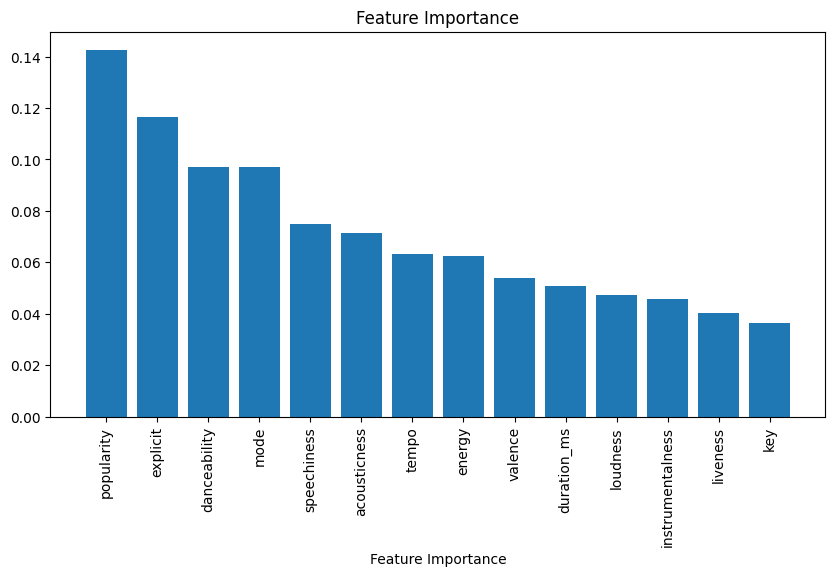

In [19]:
feature_importances = best_xgb.feature_importances_
feature_names = X.columns

# Sort and plot
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_indices], rotation=90)
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.show()